In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
import collections
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import io

from sklearn import metrics
from tflite_runtime.interpreter import Interpreter
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
import tarfile
import os

2023-01-03 22:10:52.286082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 22:10:52.764527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/satou/.local/share/virtualenvs/notebook-ysQttokH/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-03 22:10:52.764570: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-03 22:10:55.023792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynami

### download file

In [2]:
if not os.path.exists("SUN397.tar"):
    !wget http://vision.princeton.edu/projects/2010/SUN/SUN397.tar.gz
    !gunzip SUN397.tar.gz

### read images

In [3]:
def read_images(tar_filename, num_classes, num_images_per_class, rand_seed=0):
    # get filenames
    with tarfile.open(name=tar_filename, mode="r") as mytar:
        members = mytar.getmembers()
    filenames = [x.path for x in members]
    df = pd.DataFrame(data={"tarfile": members, "path": filenames})
    jpeg_df = df[df.path.str.endswith(".jpeg") | df.path.str.endswith(".jpg")].copy()
    jpeg_df["cls"] = jpeg_df.path.map(lambda x: "_".join(x.split("/")[2:-1]))
    
    # select classes
    np.random.seed(seed=rand_seed)
    selected_cls = np.random.permutation(jpeg_df.cls.unique())[:num_classes]
    
    # select images
    subdfs = []
    for cls in selected_cls:
        subdfs.append(jpeg_df[jpeg_df.cls == cls].sample(frac=1, random_state=rand_seed).iloc[:num_images_per_class])
    subdf = pd.concat(subdfs)
    
    # read images
    def load_img_from_tar(mytar, tarinfo):
        image = mytar.extractfile(tarinfo)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image
    
    tqdm.tqdm.pandas()
    with tarfile.open(name=tar_filename, mode="r") as mytar:
        subdf["image"] = subdf.tarfile.progress_apply(lambda t: load_img_from_tar(mytar, t))
    
    return subdf

In [4]:
df = read_images("./SUN397.tar", 20, 100)

100%|███████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 917.90it/s]


### calc features

In [5]:
def calc_features(df, model_path):
    interpreter = Interpreter(model_path=model_path)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.allocate_tensors()
    
    imgdata_series = df.image.progress_apply(lambda img: np.array(img.resize((224,224))))
    df["imgdata"] = imgdata_series.values
    
    df = df[df.imgdata.progress_apply(lambda x: len(x.shape)) >= 3].copy()
    
    def calc_feature(img):
        interpreter.set_tensor(input_details[0]['index'], [img.astype(np.float32) / 255])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        return output_data

    df["features"] = df.imgdata.progress_apply(calc_feature)
    
    # conv to numpy array
    features = np.stack(df.features)
    features = features.reshape((features.shape[0], features.shape[2]))
    
    features_var = np.var(features, axis=0)
    features_std = np.sqrt(features_var)
    
    return df, features, features_std

In [6]:
df, features, features_std = calc_features(df, "../app/src/main/assets/lite-model_imagenet_mobilenet_v3_small_100_224_feature_vector_5_default_1.tflite")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|███████████████████████████████████████████████████████████| 1997/1997 [00:16<00:00, 122.00it/s]


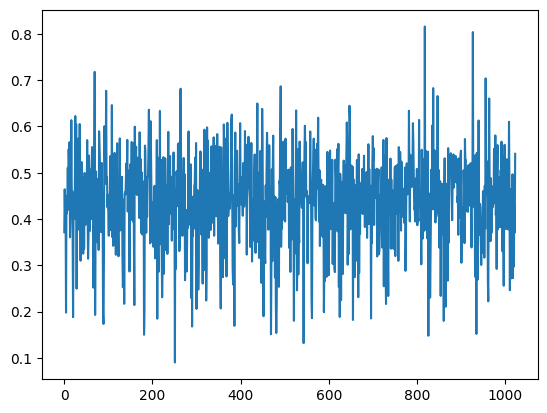

In [7]:
plt.plot(features_std)

### Plot feature distribution

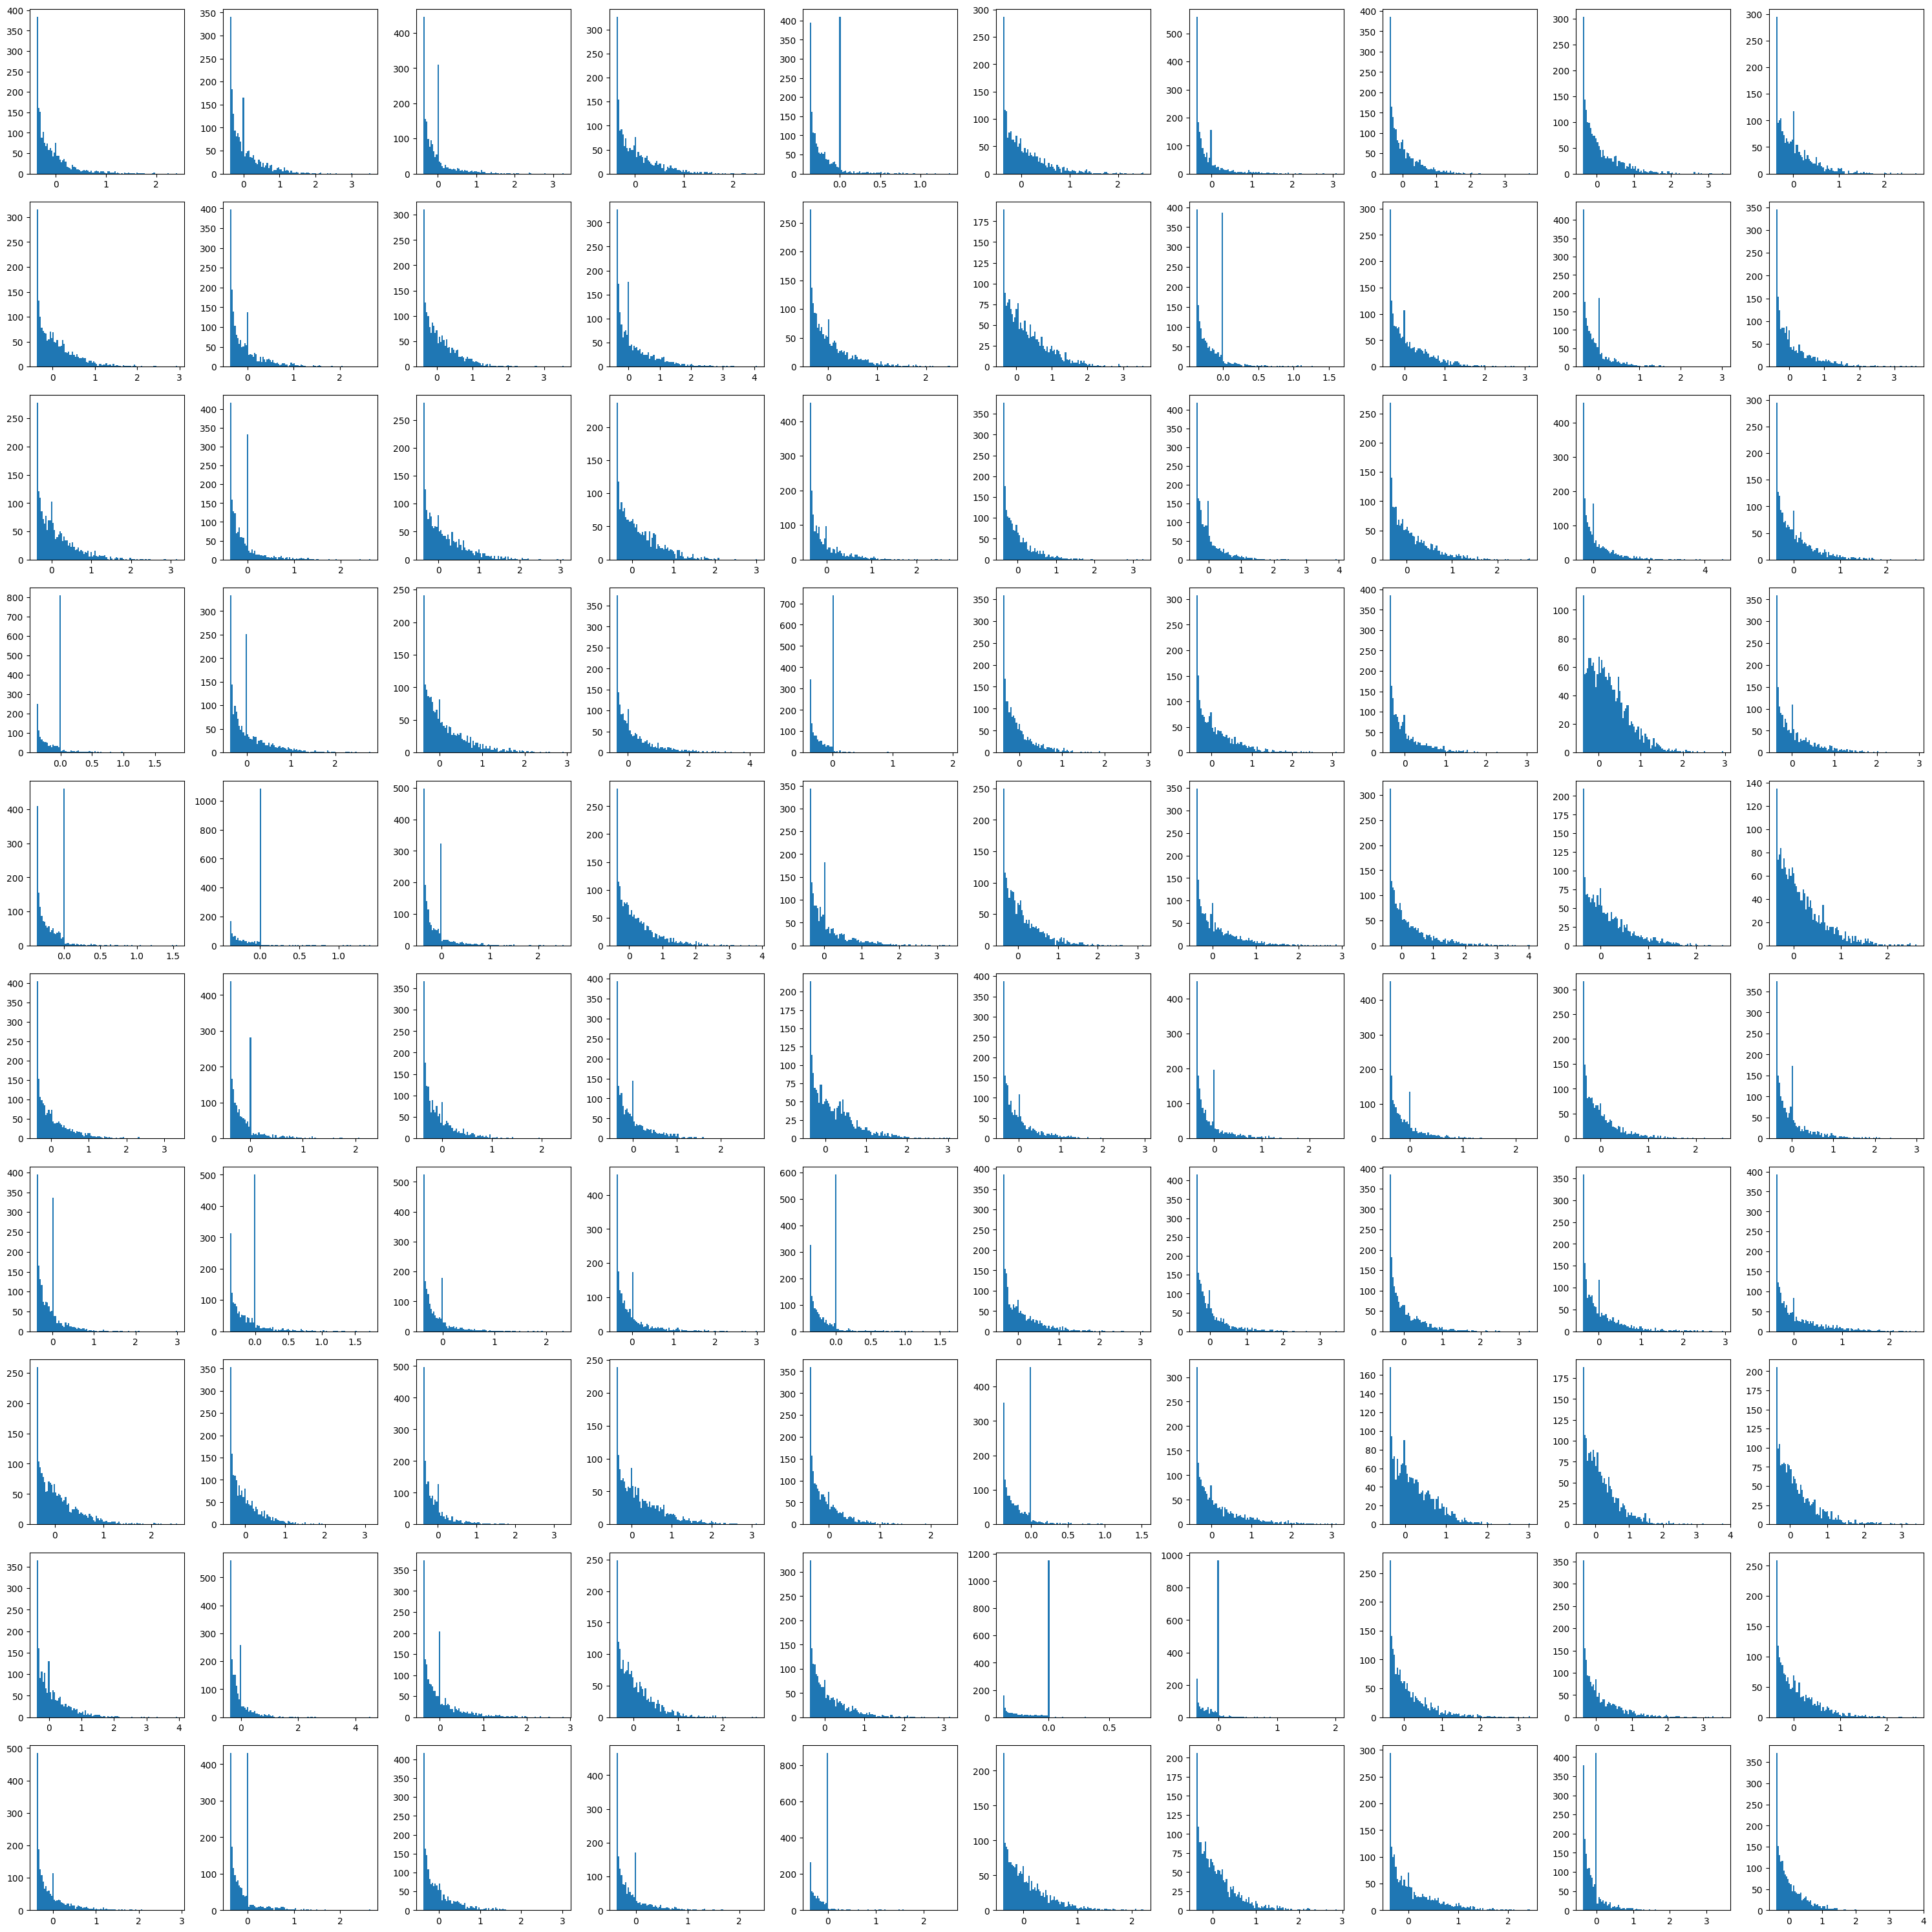

In [8]:
nrows=10
ncols=10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, tight_layout=True, figsize=(30, 30))

for row in range(nrows):
    for col in range(ncols):
        axes[row, col].hist(features[:,row*22+col], bins=100)
plt.show()

In [9]:
def calc_score(f1, f2):
    dist = np.linalg.norm(((f1 - f2) / features_std))
    #dist = np.linalg.norm(((f1 - f2) ))
    return 1 / (dist + 0.000001)

def calc_roc(sample_index, df, calc_score_func):
    sample_features = df.loc[sample_index].features
    sample_category = df.loc[sample_index].cls
    
    list_label = []
    list_score = []
    for i, row in df.iterrows():
        if i == sample_index:
            continue
        list_label.append(
            1 if sample_category == row.cls else 0
        )
        
        list_score.append(
            calc_score_func(sample_features, row.features)
        )
    
    return list_label, list_score
    

In [10]:
def calc_roc_list(df, calc_score_func):
    roc_auc_list = []
    pr_auc_list = []
    score_max_list = []
    score_min_list = []
    score_median_list = []

    for i in tqdm.tqdm(df.sort_values("cls").index):
        list_label, list_score = calc_roc(i, df, calc_score_func)
        fpr, tpr, thresholds = metrics.roc_curve(list_label, list_score)
        roc_auc = metrics.auc(fpr, tpr)
        precision, recall, thresholds = metrics.precision_recall_curve(list_label, list_score)
        pr_auc = metrics.auc(recall, precision)

        roc_auc_list.append(roc_auc)
        pr_auc_list.append(pr_auc)
        score_max_list.append(np.max(list_score))
        score_min_list.append(np.min(list_score))
        score_median_list.append(np.median(list_score))
    df["roc_auc"] = roc_auc_list
    df["pr_auc"] = pr_auc_list
    df["score_max"] = score_max_list
    df["score_min"] = score_min_list
    df["score_median"] = score_median_list
    
    return df

In [11]:
def plot_roc_auc(df):
    labels = df.cls.unique()
    box_list = [df[df.cls == c].roc_auc.values for c in labels]
    
    plt.boxplot(box_list, labels=labels, vert=False)
    plt.title('Distribution of ROC AUC')
    plt.show()
    
    print("roc auc: ", df.roc_auc.mean(), df.roc_auc.median(), df.roc_auc.max(), df.roc_auc.min())

In [12]:
def get_worst_index(df):
    return (df.roc_auc - 0.5).map(np.abs).idxmin()

def get_best_index(df):
    return (df.roc_auc - 0.5).map(np.abs).idxmax()

def plot_samples(df, anchor_index, calc_score_func):
    list_label, list_score = calc_roc(anchor_index, df, calc_score_func)
    subsubdf = df[df.index != anchor_index].copy()
    subsubdf["label"] = list_label
    subsubdf["score"] = list_score

    # plot anchor
    fig, axs = plt.subplots(1, figsize=(2, 2))
    axs.imshow(df.loc[anchor_index].imgdata)
    axs.set_title(f"anchor class={df.loc[anchor_index].cls}")
    plt.show()

    num_plot=6
    # plot false positive samples
    fig, axs = plt.subplots(ncols=num_plot, nrows=1, figsize=(10, 2))
    for ax, (i, row) in zip(axs, subsubdf[subsubdf.label == 0].sort_values("score", ascending=False).iloc[:num_plot].iterrows()):
        ax.imshow(row.imgdata)
        ax.set_title(f"fp cls={row.cls}")
    plt.tight_layout()

    # plot false negative samples
    fig, axs = plt.subplots(ncols=num_plot, nrows=1, figsize=(10, 2))
    for ax, (i, row) in zip(axs, subsubdf[subsubdf.label == 1].sort_values("score", ascending=True).iloc[:num_plot].iterrows()):
        ax.imshow(row.imgdata)
        ax.set_title(f"fn cls={row.cls}")
    plt.tight_layout()

## method1: normalize features by features_std

### calc roc auc

In [13]:
df = calc_roc_list(df, calc_score)

100%|████████████████████████████████████████████████████████████| 1997/1997 [09:45<00:00,  3.41it/s]


### plot result

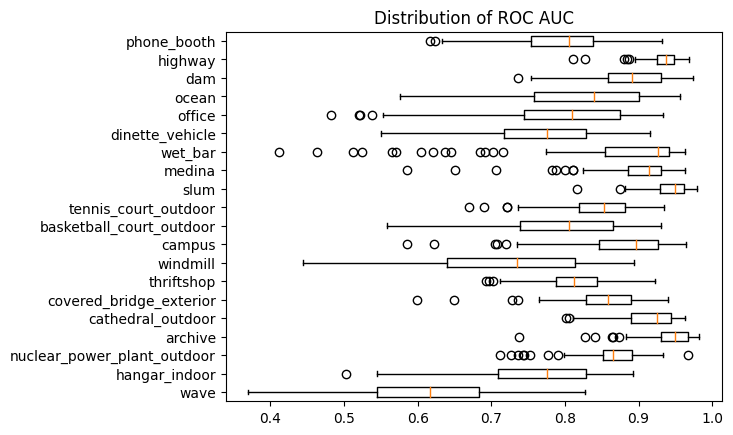

roc auc:  0.8345835391296338 0.8610671821003923 0.9821728087410744 0.36982568144927064


In [14]:
plot_roc_auc(df)

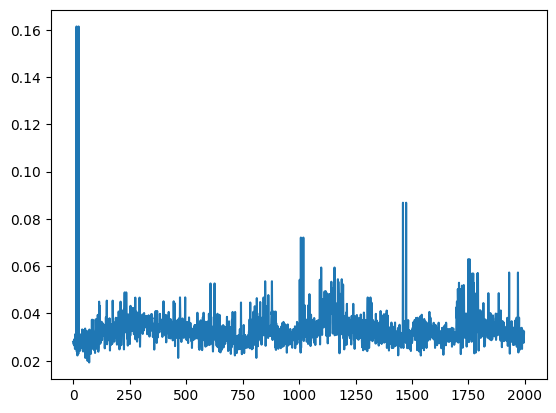

In [15]:
plt.plot(df.score_max.values)

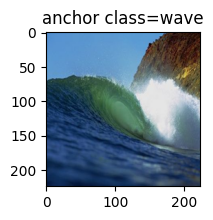

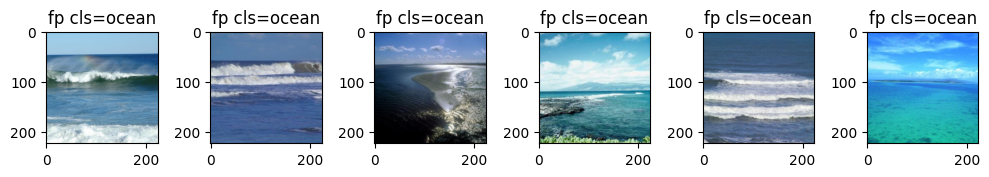

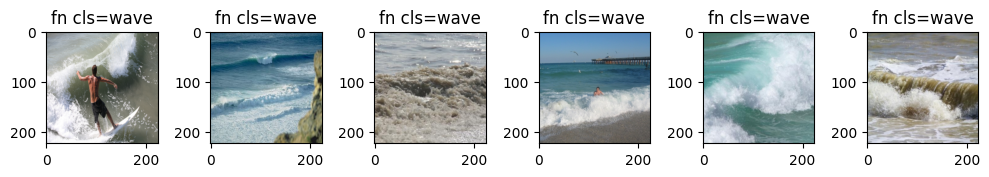

In [16]:
worst_index = get_worst_index(df)
plot_samples(df, worst_index, calc_score)

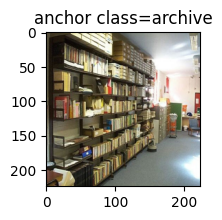

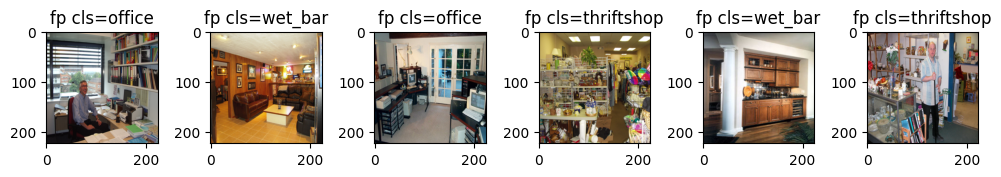

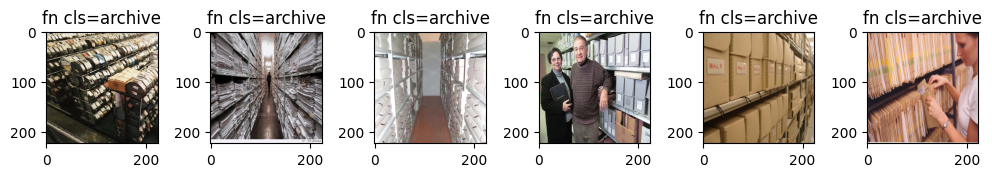

In [17]:
best_index = get_best_index(df)
plot_samples(df, best_index, calc_score)

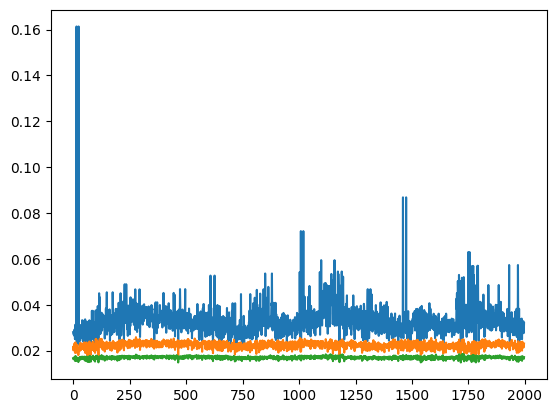

In [20]:
plt.plot(df.score_max.values)
plt.plot(df.score_median.values)
plt.plot(df.score_min.values)

## metho2: no nomalize

### calc roc auc

In [21]:
def calc_score_no_nomalize(f1, f2):
    #dist = np.linalg.norm(((f1 - f2) / features_std))
    dist = np.linalg.norm(((f1 - f2) ))
    return 1 / (dist + 0.000001)

In [22]:
df = calc_roc_list(df, calc_score_no_nomalize)

100%|████████████████████████████████████████████████████████████| 1997/1997 [09:39<00:00,  3.45it/s]


### plot result

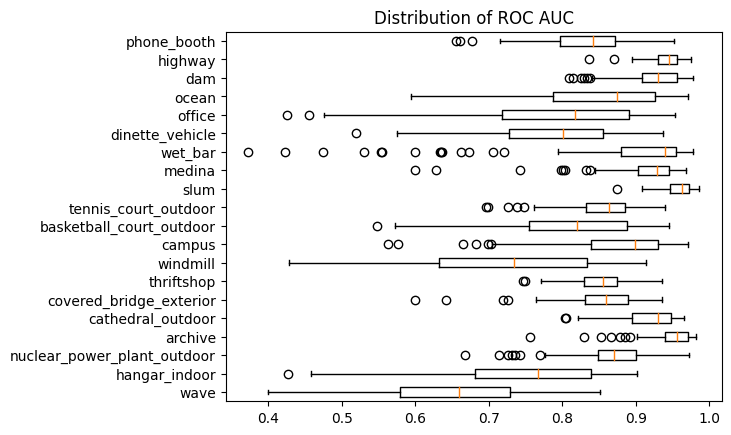

roc auc:  0.8478626597239253 0.8746026421303175 0.9861397315271854 0.3727097011229853


In [23]:
plot_roc_auc(df)

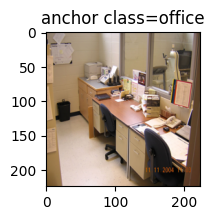

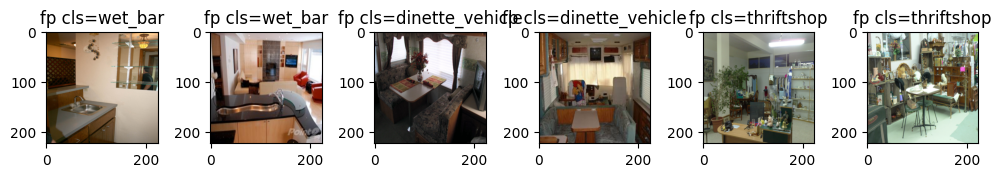

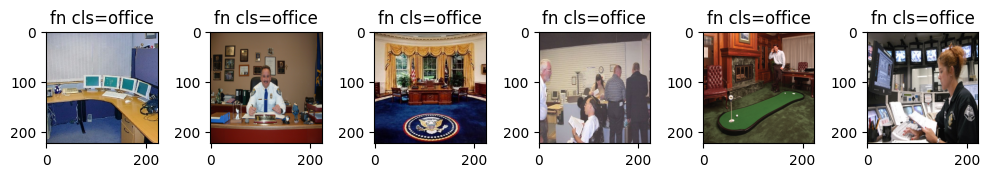

In [24]:
worst_index = get_worst_index(df)
plot_samples(df, worst_index, calc_score)

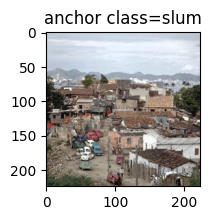

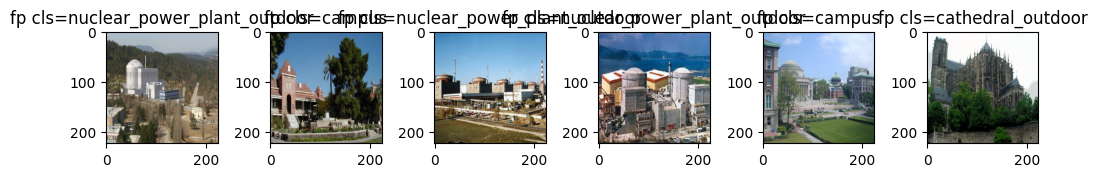

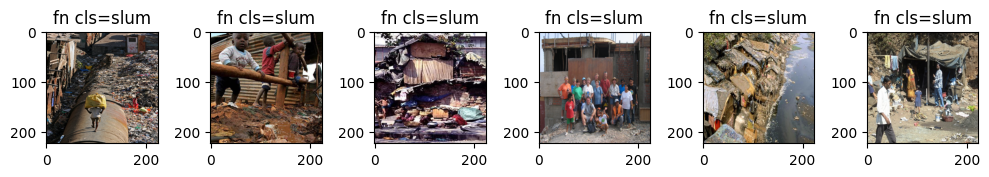

In [25]:
best_index = get_best_index(df)
plot_samples(df, best_index, calc_score)

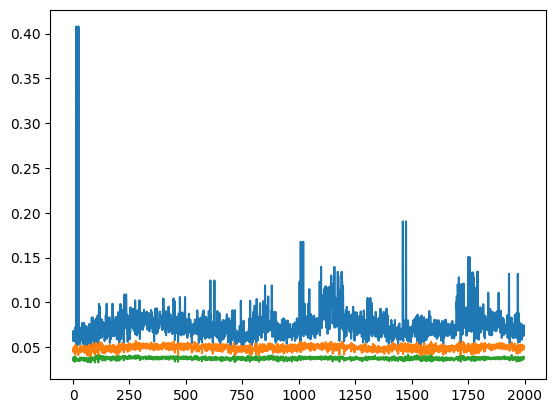

In [26]:
plt.plot(df.score_max.values)
plt.plot(df.score_median.values)
plt.plot(df.score_min.values)

## metho3: Apply weight according to feature value

### calc roc auc

In [27]:
def calc_score_no_nomalize(f1, f2):
    #dist = np.linalg.norm(((f1 - f2) / features_std))
    weight = np.maximum(f1, 0.5)
    dist = np.linalg.norm(((f1 - f2) * weight))
    return 1 / (dist + 0.000001)

In [28]:
df = calc_roc_list(df, calc_score_no_nomalize)

100%|████████████████████████████████████████████████████████████| 1997/1997 [10:22<00:00,  3.21it/s]


### plot result

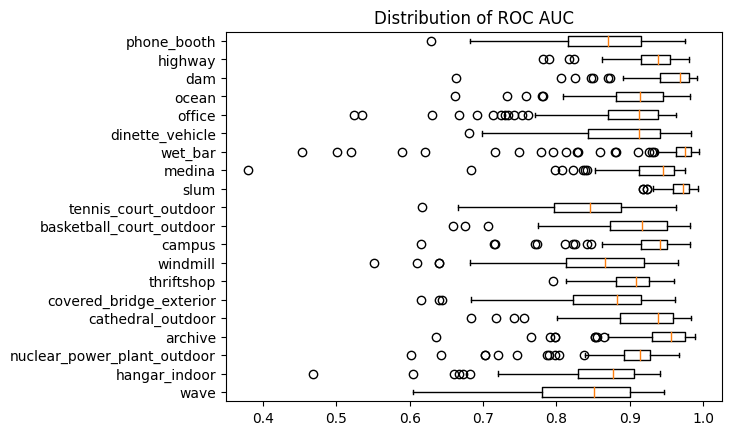

roc auc:  0.8978170284636892 0.9191812697347754 0.9944409833708727 0.3795200289665234


In [29]:
plot_roc_auc(df)

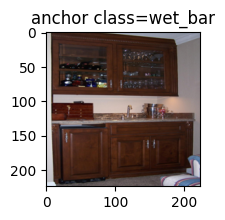

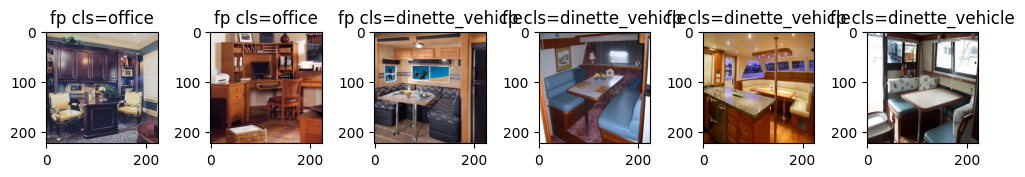

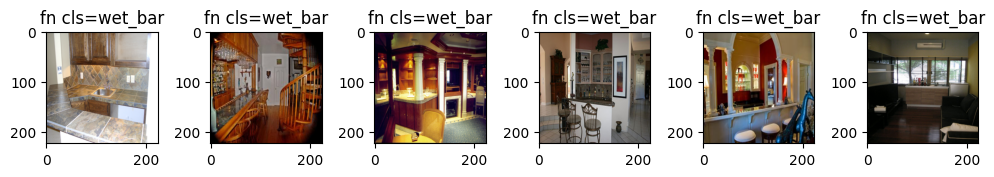

In [30]:
worst_index = get_worst_index(df)
plot_samples(df, worst_index, calc_score)

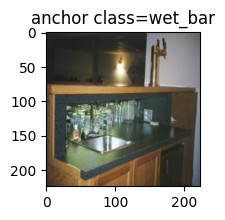

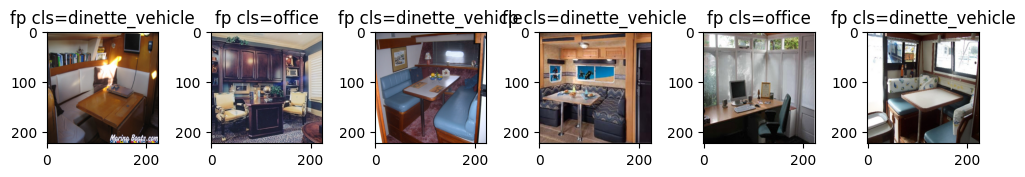

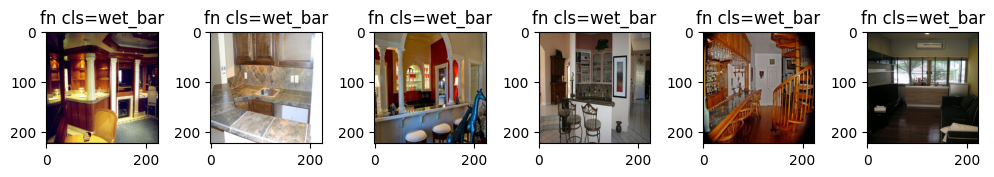

In [31]:
best_index = get_best_index(df)
plot_samples(df, best_index, calc_score)

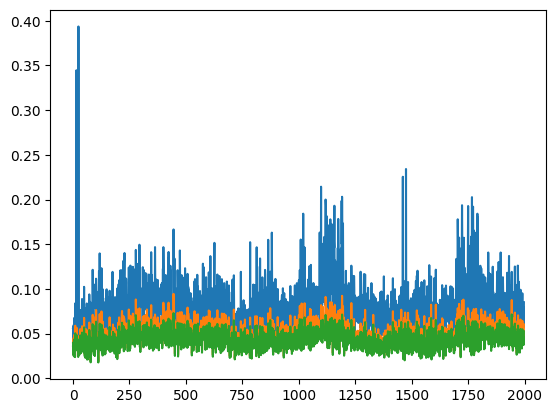

In [32]:
plt.plot(df.score_max.values)
plt.plot(df.score_median.values)
plt.plot(df.score_min.values)

## metho4: Randomly select features

### calc roc auc

In [33]:
np.random.seed(seed=10)
num_select_features = 100

In [34]:
feature_indexes = np.arange(1024)
np.random.shuffle(feature_indexes)
feature_indexes = feature_indexes[:num_select_features]

In [35]:
def calc_score_random_feature(f1, f2):
    #dist = np.linalg.norm(((f1 - f2) / features_std))
    dist = np.linalg.norm(f1.ravel()[feature_indexes] - f2.ravel()[feature_indexes])
    return 1 / (dist + 0.000001)

In [36]:
df = calc_roc_list(df, calc_score_random_feature)

100%|████████████████████████████████████████████████████████████| 1997/1997 [10:10<00:00,  3.27it/s]


### plot result

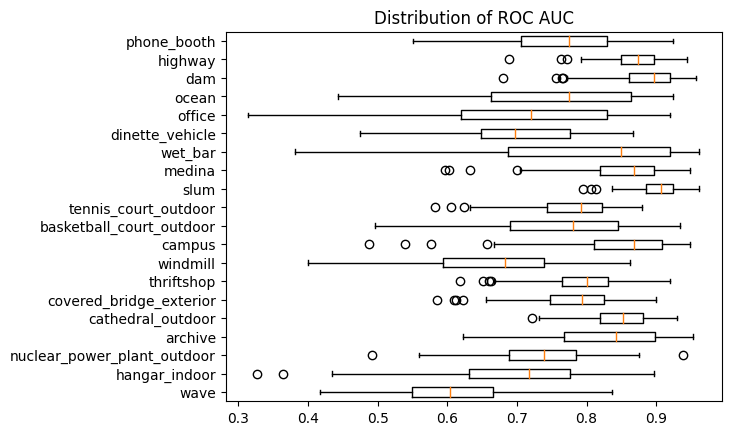

roc auc:  0.7772798246160283 0.8015739897658717 0.9616459800961645 0.3138714504028157


In [37]:
plot_roc_auc(df)

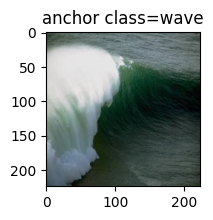

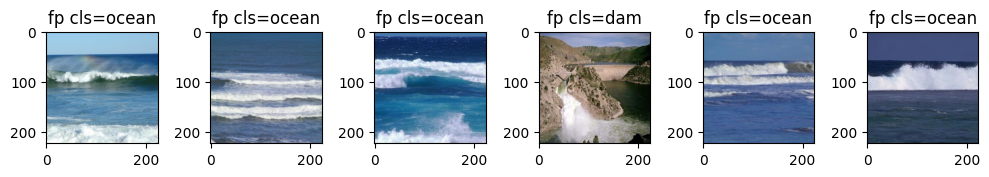

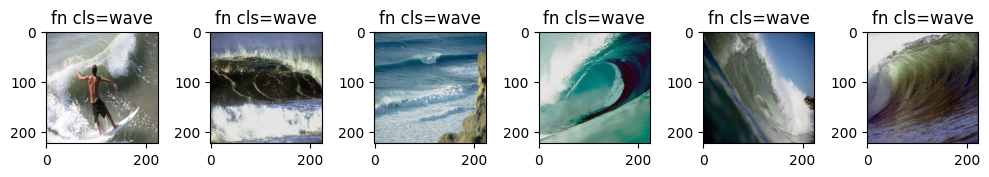

In [38]:
worst_index = get_worst_index(df)
plot_samples(df, worst_index, calc_score)

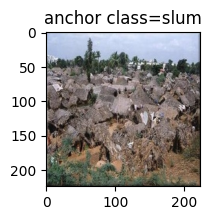

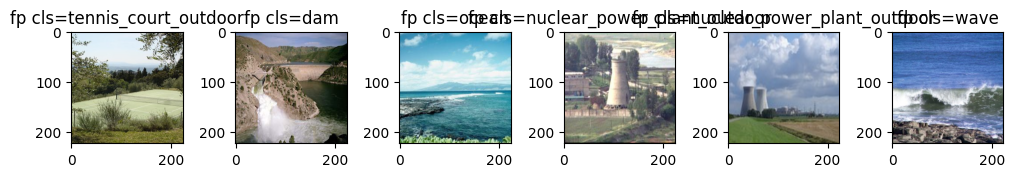

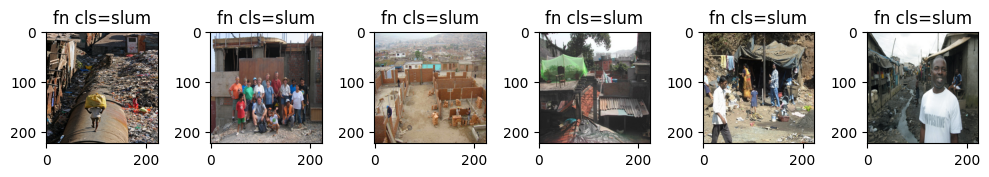

In [39]:
best_index = get_best_index(df)
plot_samples(df, best_index, calc_score)

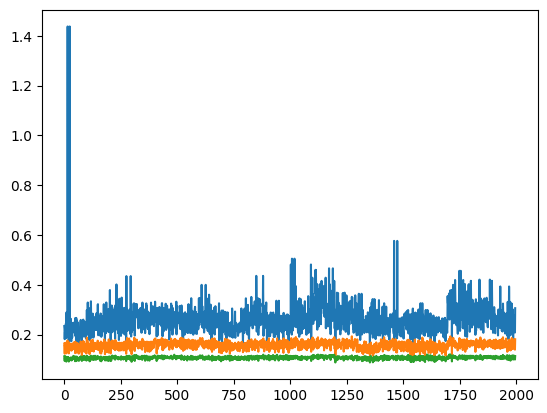

In [40]:
plt.plot(df.score_max.values)
plt.plot(df.score_median.values)
plt.plot(df.score_min.values)